# Genetic Algorithm Workshop

In this workshop we will code up a genetic algorithm for a simple mathematical optimization problem.

Genetic Algorithm is a
* Meta-heuristic
* Inspired by Natural Selection
* Traditionally works on binary data. Can be adopted for other data types as well.

You can find an example illustrating GA below
![](https://github.com/timm/sbse14/wiki/etc/img/ga.jpg)

In [29]:
%matplotlib inline
# All the imports
from __future__ import print_function, division
from math import *
import random
import sys
import matplotlib.pyplot as plt

# TODO 1: Enter your unity ID here 
__author__ = "pranjan"

class O:
    """
    Basic Class which
        - Helps dynamic updates
        - Pretty Prints
    """
    def __init__(self, **kwargs):
        self.has().update(**kwargs)
    def has(self):
        return self.__dict__
    def update(self, **kwargs):
        self.has().update(kwargs)
        return self
    def __repr__(self):
        show = [':%s %s' % (k, self.has()[k]) 
                for k in sorted(self.has().keys()) 
                if k[0] is not "_"]
        txt = ' '.join(show)
        if len(txt) > 60:
            show = map(lambda x: '\t' + x + '\n', show)
        return '{' + ' '.join(show) + '}'
    
print("Unity ID: ", __author__)

Unity ID:  pranjan


### The optimization problem
The problem we are considering is a mathematical one 
<img src="cone.png" width=500px/>

**Decisions**: *r* in [0, 10] cm; *h* in [0, 20] cm

**Objectives**: minimize *S*, *T*

**Constraints**: *V* > 200cm<sup>3</sup>

In [30]:
# Few Utility functions
def say(*lst):
    """
    Print whithout going to new line
    """
    print(*lst, end="")
    sys.stdout.flush()

def random_value(low, high, decimals=2):
    """
    Generate a random number between low and high. 
    decimals incidicate number of decimal places
    """
    return round(random.uniform(low, high),decimals)

def gt(a, b): return a > b

def lt(a, b): return a < b

def shuffle(lst):
    """
    Shuffle a list
    """
    random.shuffle(lst)
    return lst

class Decision(O):
    """
    Class indicating Decision of a problem
    """
    def __init__(self, name, low, high):
        """
        @param name: Name of the decision
        @param low: minimum value
        @param high: maximum value
        """
        O.__init__(self, name=name, low=low, high=high)
        
class Objective(O):
    """
    Class indicating Objective of a problem
    """
    def __init__(self, name, do_minimize=True):
        """
        @param name: Name of the objective
        @param do_minimize: Flag indicating if objective has to be minimized or maximized
        """
        O.__init__(self, name=name, do_minimize=do_minimize)

class Point(O):
    """
    Represents a member of the population
    """
    def __init__(self, decisions):
        O.__init__(self)
        self.decisions = decisions
        self.objectives = None
        
    def __hash__(self):
        return hash(tuple(self.decisions))
    
    def __eq__(self, other):
        return self.decisions == other.decisions
    
    def clone(self):
        new = Point(self.decisions)
        new.objectives = self.objectives
        return new

class Problem(O):
    """
    Class representing the cone problem.
    """
    def __init__(self):
        O.__init__(self)
        # TODO 2: Code up decisions and objectives below for the problem
        # using the auxilary classes provided above.
        self.decisions = [Decision('r', 0, 10), Decision('h', 0, 20)]
        self.objectives = [Objective('S'), Objective('T')]
        
    @staticmethod
    def evaluate(point):
        [r, h] = point.decisions
        # TODO 3: Evaluate the objectives S and T for the point.
        l = sqrt(r**2 + h**2)
        S = pi * r * l
        T = pi * r * (r + l)
        point.objectives = [S, T]
        return point.objectives
    
    @staticmethod
    def is_valid(point):
        [r, h] = point.decisions
        # TODO 4: Check if the point has valid decisions
        return (pi * r * r * h / 3.0) > 200
    
    def generate_one(self):
        # TODO 5: Generate a valid instance of Point.
        while True:
            r = random_value(0, 10)
            h = random_value(0, 20)
            point = Point([r, h])
            if Problem.is_valid(point):
                return point
            
cone = Problem()
point = cone.generate_one()
cone.evaluate(point)
print(point)

{	:decisions [4.68, 14.2]
 	:objectives [219.82429065457342, 288.6327095905585]
}


Great. Now that the class and its basic methods is defined, we move on to code up the GA.
### Population
First up is to create an initial population. 

In [31]:
def populate(problem, size):
    # TODO 6: Create a list of points of length 'size'
    return [problem.generate_one() for _ in range(size)]

# or if ur python OBSESSED
#        return [problem.generate_one() for _ in xrange(size)]

for x in populate(cone, 5):
    print(x)


{:decisions [7.66, 4.73] :objectives None}
{:decisions [8.93, 17.71] :objectives None}
{:decisions [6.04, 17.4] :objectives None}
{:decisions [5.37, 12.0] :objectives None}
{:decisions [8.57, 10.5] :objectives None}


### Crossover
We perform a single point crossover between two points

In [32]:
def crossover(mom, dad):
    # TODO 7: Create a new point which contains decisions from 
    # the first half of mom and second half of dad
    return Point([mom.decisions[0], dad.decisions[1]])

pop = populate(cone,5)
crossover(pop[0], pop[1])

{:decisions [9.18, 10.18] :objectives None}

### Mutation
Randomly change a decision such that 

In [33]:
def mutate(problem, point, mutation_rate=0.01):
    # TODO 8: Iterate through all the decisions in the problem
    # and if the probability is less than mutation rate
    # change the decision(randomly set it between its max and min).
    asd = list()
    for i, dec in enumerate(problem.decisions):
        if random_value(0,1) < mutation_rate:
            asd.append(random_value(dec.low, dec.high))
        else:
            asd.append(point.decisions[i])

    return Point(asd)


### Fitness Evaluation
To evaluate fitness between points we use binary domination. Binary Domination is defined as follows:
* Consider two points one and two.
* For every objective **o** and **t** in **one** and **two**, **o** <= **t**
* Atleast one objective **o** and **t** in **one** and **two**, **o** < **t**

**Note**: Binary Domination is not the best method to evaluate fitness but due to its simplicity we choose to use it for this workshop.


In [34]:
def bdom(problem, one, two):
    """
    Return if one dominates two
    """
    objs_one = problem.evaluate(one)
    objs_two = problem.evaluate(two)
    dominates = False
    # TODO 9: Return True/False based on the definition
    # of bdom above.
    try:
        for o, t in zip(objs_one, objs_two):
            assert o >= t
            if o > t:
                dominates = True
    except AssertionError:
        return False
    return dominates


### Fitness and Elitism

In this workshop we will count the number of points of the population P dominated by a point A as the fitness of point A. This is a very naive measure of fitness since we are using binary domination. 

Few prominent alternate methods are
1. [Continuous Domination](http://www.tik.ee.ethz.ch/sop/publicationListFiles/zk2004a.pdf) - Section 3.1
2. [Non-dominated Sort](http://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=996017)
3. [Non-dominated Sort + Niching](http://www.egr.msu.edu/~kdeb/papers/k2012009.pdf)

**Elitism**: Sort points with respect to the fitness and select the top points.

In [35]:
def fitness(problem, population, point):
    dominates = 0
    # TODO 10: Evaluate fitness of a point.
    # For this workshop define fitness of a point 
    # as the number of points dominated by it.
    # For example point dominates 5 members of population,
    # then fitness of point is 5.
    return sum([bdom(problem, point, chromosome) for chromosome in population])
    
def elitism(problem, population, retain_size):
    # TODO 11: Sort the population with respect to the fitness
    # of the points and return the top 'retain_size' points of the population
    population = sorted(population, key= lambda x: fitness(problem, population, x))
    return population[:retain_size]


### Putting it all together and making the GA

In [36]:
def ga(pop_size = 100, gens = 250):
    problem = Problem()
    population = populate(problem, pop_size)
    [problem.evaluate(point) for point in population]
    initial_population = [point.clone() for point in population]
    gen = 0 
    while gen < gens:
        say(".")
        children = []
        for _ in range(pop_size):
            mom = random.choice(population)
            dad = random.choice(population)
            while (mom == dad):
                dad = random.choice(population)
            child = mutate(problem, crossover(mom, dad))
            if problem.is_valid(child) and child not in population+children:
                children.append(child)
        population += children
        population = elitism(problem, population, pop_size)
        gen += 1
    print("")
    return initial_population, population

### Visualize
Lets plot the initial population with respect to the final frontier.

In [37]:
def plot_pareto(initial, final):
    initial_objs = [point.objectives for point in initial]
    final_objs = [point.objectives for point in final]
    initial_x = [i[0] for i in initial_objs]
    initial_y = [i[1] for i in initial_objs]
    final_x = [i[0] for i in final_objs]
    final_y = [i[1] for i in final_objs]
    plt.scatter(initial_x, initial_y, color='b', marker='+', label='initial')
    plt.scatter(final_x, final_y, color='r', marker='o', label='final')
    plt.title("Scatter Plot between initial and final population of GA")
    plt.ylabel("Total Surface Area(T)")
    plt.xlabel("Curved Surface Area(S)")
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.175), ncol=2)
    plt.show()
    

..........................................................................................................................................................................................................................................................


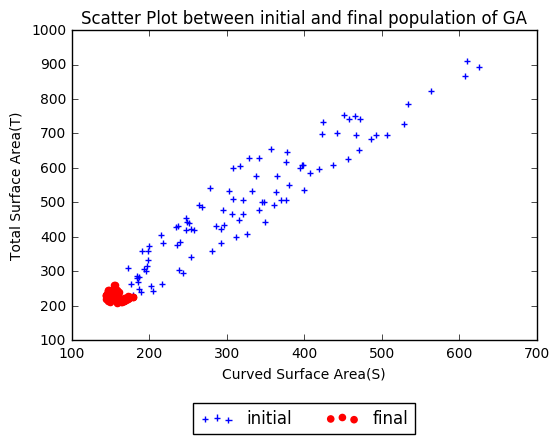

In [38]:
initial, final = ga()
plot_pareto(initial, final)

Here is a sample output
<img src="sample.png" width=300/>